In [8]:
import pyspark
sc = pyspark.SparkContext()

In [9]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql.functions import when
from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer
from pyspark.ml.feature import Normalizer, MinMaxScaler, VectorAssembler, StandardScaler
from pyspark.sql import Row, Column
from pyspark.sql.types import FloatType, DoubleType
import plotly.graph_objects as go
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.tree import DecisionTree as DT
from pyspark.mllib.tree import DecisionTreeModel, LabeledPoint

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.tree import LabeledPoint

from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
import itertools


from pyspark.ml import Pipeline
from pyspark.sql.functions import udf

from pyspark.ml.feature import StringIndexer, VectorIndexer, StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics


In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
spark = SparkSession.builder \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [17]:
clusters_path = "hdfs://kddrtserver13.isti.cnr.it:9000/user/hpsa15/kmeans_cluster_"
optimals_path = "hdfs://kddrtserver13.isti.cnr.it:9000/user/hpsa15/decisiontree_optimals.csv"

- Numeri dei clusters

In [49]:
prediction_v = [0, 1, 2, 3, 4, 5]

- Lettura dei clusters

In [34]:
clusters_df = {}
for i in prediction_v:
    clusters_df[i] = spark.read.options(inferSchema = True, header = True)\
                .csv(clusters_path+str(i)+".csv")

In [ ]:
features_numeric = ["age", "duration", "campaign", "pdays", "previous",
                  "emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor3m",
                  "nr_employed"]

- 3Fold-CrossValidation

In [23]:
def exec_crossEvalTree(df, prediction_v):
    optimals = {}
    for i in prediction_v:
        # Assemblaggio del clusters
        assembler = VectorAssembler().setInputCols(features_numeric).setOutputCol("features")
        tmp_df = assembler.transform(df[i])
        tmp_df =tmp_df.withColumnRenamed("y","label")
        # Training e test
        train, test = tmp_df.randomSplit([0.7, 0.3], seed = 2)
        
        # Create initial Decision Tree Model
        model = DecisionTreeClassifier(labelCol="label", featuresCol="features")
        
        # Create ParamGrid for Cross Validation
        model_paramGrid = (ParamGridBuilder()
               .addGrid(model.impurity, ["entropy", "gini"])
               .addGrid(model.maxDepth, [2, 5, 10, 15])
               .addGrid(model.maxBins, [2, 5, 10, 15]).build())
        # Evaluate model
        model_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

        # Create 3-fold CrossValidator
        cross_model = CrossValidator(estimator = model,
                              estimatorParamMaps = model_paramGrid,
                              evaluator = model_evaluator,
                              numFolds = 3)

        # Run cross validations
        fit_model = cross_model.fit(train)
        print(fit_model)

        
        bestModel = fit_model.bestModel
        extract_par = bestModel.extractParamMap()
        best_parameters = {}
        best_parameters["impurity"] = extract_par[bestModel.getParam("impurity")]
        best_parameters["maxDepth"] = extract_par[bestModel.getParam("maxDepth")]
        best_parameters["maxBins"] = extract_par[bestModel.getParam("maxBins")]
        print(best_parameters)
        optimals[i] = best_parameters
        print(optimals)
    return optimals

In [110]:
optimals = exec_crossEvalTree(clusters_df, prediction_v)

CrossValidatorModel_1e5f7a2813bd
{'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 15}
{1: {'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 15}}
CrossValidatorModel_5b1f496f16f6
{'impurity': 'entropy', 'maxDepth': 2, 'maxBins': 2}
{1: {'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 15}, 3: {'impurity': 'entropy', 'maxDepth': 2, 'maxBins': 2}}
CrossValidatorModel_51247dde651c
{'impurity': 'gini', 'maxDepth': 5, 'maxBins': 5}
{1: {'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 15}, 3: {'impurity': 'entropy', 'maxDepth': 2, 'maxBins': 2}, 5: {'impurity': 'gini', 'maxDepth': 5, 'maxBins': 5}}
CrossValidatorModel_84dc571d2b6e
{'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 5}
{1: {'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 15}, 3: {'impurity': 'entropy', 'maxDepth': 2, 'maxBins': 2}, 5: {'impurity': 'gini', 'maxDepth': 5, 'maxBins': 5}, 4: {'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 5}}
CrossValidatorModel_60d2f789990c
{'impurity': 'entropy', 'maxDepth': 15, 'maxBins': 15

In [111]:
optimals

{1: {'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 15},
 3: {'impurity': 'entropy', 'maxDepth': 2, 'maxBins': 2},
 5: {'impurity': 'gini', 'maxDepth': 5, 'maxBins': 5},
 4: {'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 5},
 2: {'impurity': 'entropy', 'maxDepth': 15, 'maxBins': 15},
 0: {'impurity': 'entropy', 'maxDepth': 5, 'maxBins': 15}}

- Salvataggio valori ottimi (backup)

In [56]:
"""
# Eseguire solo se è stata eseguita la crossvalidation
def opt_towrite(optimals):
    ll = []
    for i in range(0, 6):
        x ={}
        x["clusters"] = i
        x["impurity"] = optimals[i]["impurity"]
        x["maxDepth"] = optimals[i]["maxDepth"]
        x["maxBins"] = optimals[i]["maxBins"]
        ll.append(x)
    df_optimals = spark.createDataFrame(ll)
    df_optimals.write.format("csv").save("hdfs://kddrtserver13.isti.cnr.it:9000/user/hpsa15/decisiontree_optimals.csv", header = True)

opt_towrite(optimals)
"""

'\n# Eseguire solo se è stata eseguita la crossvalidation\ndef opt_towrite(optimals):\n    ll = []\n    for i in range(0, 6):\n        x ={}\n        x["clusters"] = i\n        x["impurity"] = optimals[i]["impurity"]\n        x["maxDepth"] = optimals[i]["maxDepth"]\n        x["maxBins"] = optimals[i]["maxBins"]\n        ll.append(x)\n    df_optimals = spark.createDataFrame(ll)\n    df_optimals.write.format("csv").save("hdfs://kddrtserver13.isti.cnr.it:9000/user/hpsa15/decisiontree_optimals.csv", header = True)\n\nopt_towrite(optimals)\n'

In [32]:
"""optimals_df = spark.read.options(inferSchema = True, header = True)\
                .csv(optimals_path)    
optimals_df.show()"""

'optimals_df = spark.read.options(inferSchema = True, header = True)                .csv(optimals_path)    \noptimals_df.show()'

#### 1. Creazione dei labaled points per training e test (label point = target)
#### 2. Split in training e test dei dataframe

Esempio di accesso al cluster n:
 - Cluster n:  splitted_clusters[n]

Esempio di accesso al training/test del cluster n:
 - Training :  splitted_clusters[n][0]
 - Test : splitted_clusters[n][1]

In [50]:
def split_traintest(df, prediction):
    splitted_clusters = {}
    for i in prediction:
        print(i)
        labeled = df[i].rdd.map(lambda row: LabeledPoint(row[20], [row[0:1] + row[10:14] + row[15:20]]))
        # Sovrascriviamo il dizionario mettendo per ogni indice di cluster la coppia di RDD <training, test>
        splitted_clusters[i] = labeled.randomSplit([0.7, 0.3])
    return splitted_clusters

In [51]:
splitted_clusters = split_traintest(clusters_df, prediction_v)

0
1
2
3
4
5


- Funzione per plottare la confusion matrix

In [52]:
def plt_matrix(matrix, title):
    # Normalizzazione della matrice
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Aperto", "Non-Aperto"], rotation=45)
    plt.yticks(tick_marks, ["Aperto", "Non-Aperto"])

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid()
    plt.tight_layout()
    plt.plot()

- Funzione per stampare le metriche

In [53]:
def performance(df, title):
    metrics = MulticlassMetrics(df)
  
    print('  Accuracy '+str(metrics.accuracy))
    print('  F-1 Score         '+ str(metrics.fMeasure()))
    print('  Precision (False) '+ str(metrics.precision(0)))
    print('  Precision (True) '+str(metrics.precision(1)))
    print('  Recall (False)   '+str(metrics.recall(0)))
    print('  Recall (True)    '+str(metrics.recall(1)))
    print('  Confusion Matrix')
    matrix = metrics.confusionMatrix().toArray()
    print(matrix)
    plt_matrix(matrix, title)

- Funzione per stampare roc_auc

In [54]:
def roc_auc_plot(res, title):

    results_list = res.collect()
    y_score = [i[0] for i in results_list]
    y_test = [i[1] for i in results_list]
    
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    print("AUC MLlib: " + str(BinaryClassificationMetrics(res).areaUnderROC))
    %matplotlib inline
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.plot()

In [62]:
def get_labels_plot(model, data, title):    
    # 1 - Valore target predetto
    predictions = model.predict(data.map(lambda r: r.features))
    # 2 - Etichette per performance
    labels_ = predictions.zip(data.map(lambda r: r.label))
    # 3 - Stampa Performance
    performance(labels_, title)
    
"""
    # 4 - Valore target reale
    actual = test.map(lambda x: x.label)
    # 5 - Dataframe valori target predetti: (target_predetto, indice)
    df_prediction = predictions.zipWithIndex().toDF(['predicted_label', 'index'])
    # 6 - Dataframe valori target attuali: (target_attuale, indice)
    df_actual = predictions.zipWithIndex().toDF(['actual_label', 'index'])
    # 7 - JOIN dei dataframe tramite indice
    join_df = df_actual.join(df_prediction, df_actual.index == df_prediction.index).drop('index')

    # 8 - Count di Predizioni corrette (1) e predizioni errate (0)
    print("          - Count predizioni corrette (=1) vs errate (=0) - ")
    x = join_df.withColumn('correct_predictions', when(join_df['actual_label'] == join_df['predicted_label'], 1).otherwise(0))
    x.groupBy('correct_predictions').count().show()

    # 9 - Classificazioni sbagliate
    print("          - Count predizioni errate - ")
    x.filter(x['correct_predictions'] == 0.0).groupBy('actual_label').count().show()

    # 10 - Creazione RDD
    resRDD = join_df.rdd.map(tuple)

    # 11 - Plot ROC-AUC
    print("          - Plot ROC AUC - ")
    roc_auc_plot(resRDD, title)  
"""

'\n    # 4 - Valore target reale\n    actual = test.map(lambda x: x.label)\n    # 5 - Dataframe valori target predetti: (target_predetto, indice)\n    df_prediction = predictions.zipWithIndex().toDF([\'predicted_label\', \'index\'])\n    # 6 - Dataframe valori target attuali: (target_attuale, indice)\n    df_actual = predictions.zipWithIndex().toDF([\'actual_label\', \'index\'])\n    # 7 - JOIN dei dataframe tramite indice\n    join_df = df_actual.join(df_prediction, df_actual.index == df_prediction.index).drop(\'index\')\n\n    # 8 - Count di Predizioni corrette (1) e predizioni errate (0)\n    print("          - Count predizioni corrette (=1) vs errate (=0) - ")\n    x = join_df.withColumn(\'correct_predictions\', when(join_df[\'actual_label\'] == join_df[\'predicted_label\'], 1).otherwise(0))\n    x.groupBy(\'correct_predictions\').count().show()\n\n    # 9 - Classificazioni sbagliate\n    print("          - Count predizioni errate - ")\n    x.filter(x[\'correct_predictions\'] == 0.

- Esecuzione del Decision Tree per ogni cluster

In [63]:
def exec_decisionTree(df, prediction_v, optimals):
    for i in prediction_v:
        cc = optimals[i]
        train, test = df[i]
        model = DT.trainClassifier(train, numClasses=2, 
                                             #categoricalFeaturesInfo = categoricalFeaturesInfo,
                                             categoricalFeaturesInfo = {},
                                            impurity = cc["impurity"],
                                            maxDepth=cc["maxDepth"],
                                            maxBins=cc["maxBins"])
        
        print("<--------------- Metriche per cluster = "+ str(i) + " ---------------->")
        print("          |  TRAINING  |")
        get_labels_plot(model, train, "Training cluster "+ str(i))
        print("          |    TEST    |")
        get_labels_plot(model, test, "Test cluster "+ str(i))

<--------------- Metriche per cluster = 0 ---------------->
          |  TRAINING  |
  Accuracy 0.8747072599531616
  F-1 Score         0.8747072599531616
  Precision (False) 0.9364341085271318
  Precision (True) 0.6952998379254457
  Recall (False)   0.9133064516129032
  Recall (True)    0.7422145328719724
  Confusion Matrix
[[1810.  195.]
 [ 124.  433.]]
          |    TEST    |
  Accuracy 0.8340971585701191
  F-1 Score         0.8340971585701191
  Precision (False) 0.896168108776267
  Precision (True) 0.6423611111111112
  Recall (False)   0.8777239709443099
  Recall (True)    0.6981132075471698
  Confusion Matrix
[[720. 108.]
 [ 74. 189.]]
<--------------- Metriche per cluster = 1 ---------------->
          |  TRAINING  |
  Accuracy 0.928200129954516
  F-1 Score         0.928200129954516
  Precision (False) 0.9486685474437487
  Precision (True) 0.5454545454545454
  Recall (False)   0.9742085924250989
  Recall (True)    0.40226171243941844
  Confusion Matrix
[[13777.   381.]
 [  746. 

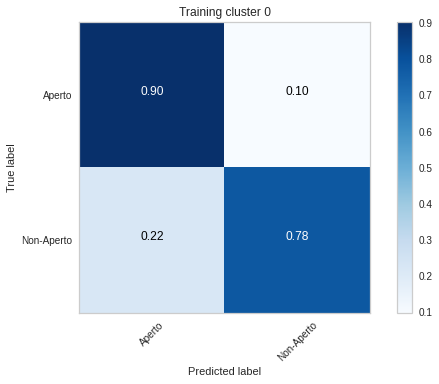

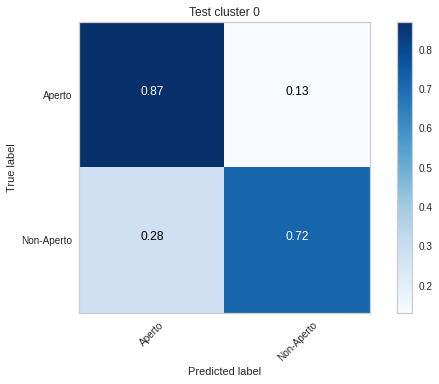

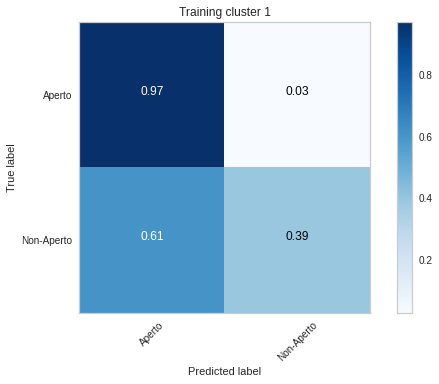

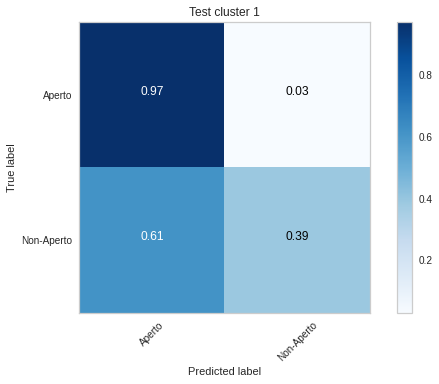

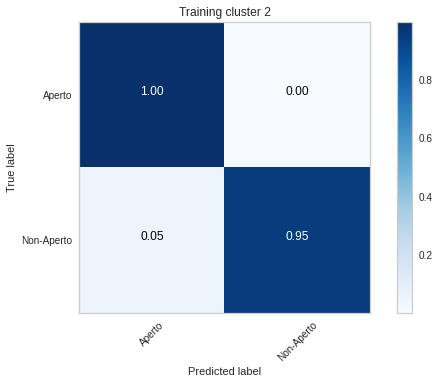

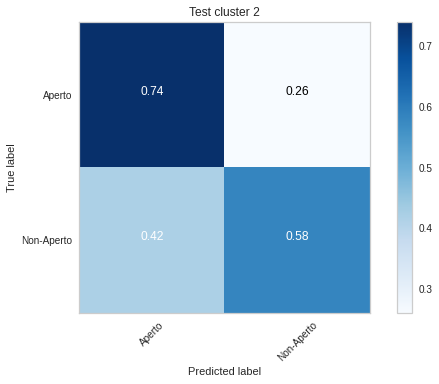

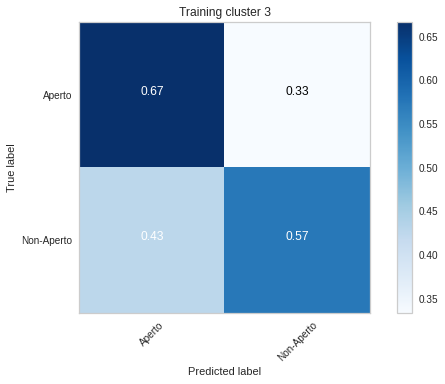

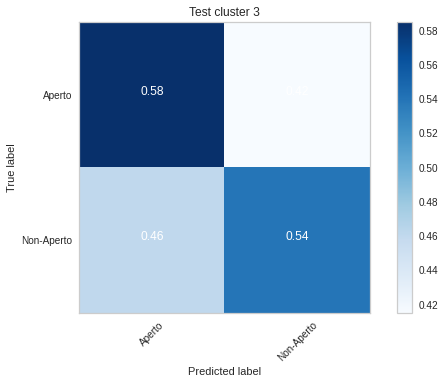

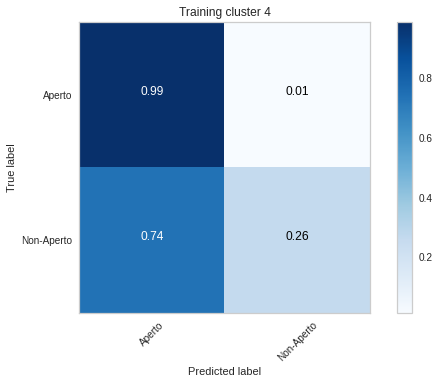

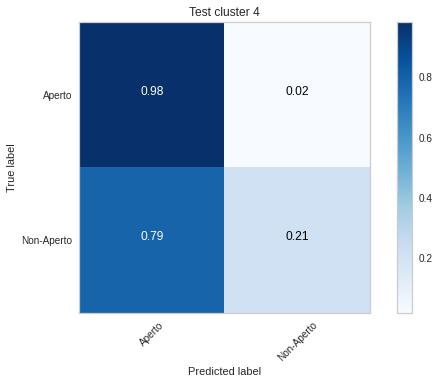

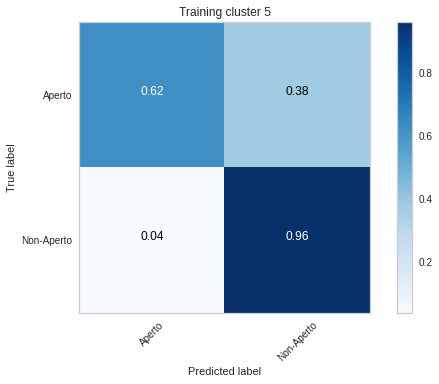

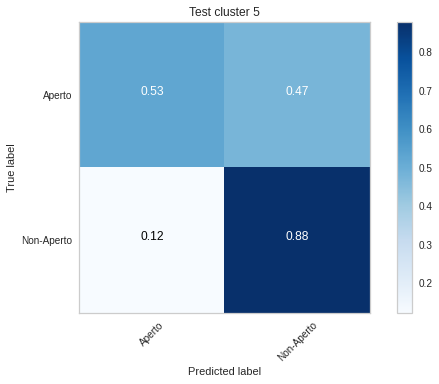

In [64]:
exec_decisionTree(splitted_clusters, prediction_v, optimals)

In [65]:
cc = optimals[0]
train, test = splitted_clusters[0]
model = DT.trainClassifier(train, numClasses=2, 
                                             #categoricalFeaturesInfo = categoricalFeaturesInfo,
                                            categoricalFeaturesInfo = {},
                                            impurity = cc["impurity"],
                                            maxDepth=cc["maxDepth"],
                                            maxBins=cc["maxBins"])

In [72]:
feature_columns = ["age", "duration", "campaign", "pdays", "previous",
                   "emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor3m", "nr_employed"]

In [74]:
tree = model.toDebugString()
for i in range(0,len(feature_columns)):
    tree=tree.replace("feature "+str(i)+" ", str(feature_columns[i])+" ")
print(tree)

DecisionTreeModel classifier of depth 5 with 37 nodes
  If (nr_employed <= 5087.65)
   If (duration <= 154.5)
    If (pdays <= -0.5)
     Predict: 0.0
    Else (pdays > -0.5)
     If (campaign <= 3.5)
      If (duration <= 112.5)
       Predict: 0.0
      Else (duration > 112.5)
       Predict: 1.0
     Else (campaign > 3.5)
      Predict: 0.0
   Else (duration > 154.5)
    If (pdays <= 1.5)
     If (duration <= 261.5)
      Predict: 0.0
     Else (duration > 261.5)
      If (age <= 42.5)
       Predict: 1.0
      Else (age > 42.5)
       Predict: 0.0
    Else (pdays > 1.5)
     Predict: 1.0
  Else (nr_employed > 5087.65)
   If (duration <= 435.5)
    If (pdays <= 1.5)
     Predict: 0.0
    Else (pdays > 1.5)
     If (duration <= 175.5)
      Predict: 0.0
     Else (duration > 175.5)
      If (pdays <= 7.5)
       Predict: 1.0
      Else (pdays > 7.5)
       Predict: 0.0
   Else (duration > 435.5)
    If (duration <= 591.0)
     If (pdays <= -0.5)
      If (campaign <= 4.5)
       Pred

In [80]:
cc = optimals[1]
train, test = splitted_clusters[1]
model = DT.trainClassifier(train, numClasses=2, 
                                             #categoricalFeaturesInfo = categoricalFeaturesInfo,
                                            categoricalFeaturesInfo = {},
                                            impurity = cc["impurity"],
                                            maxDepth=cc["maxDepth"],
                                            maxBins=cc["maxBins"])
tree = model.toDebugString()
for i in range(0,len(feature_columns)):
    tree=tree.replace("feature "+str(i)+" ", str(feature_columns[i])+" ")
print(tree)

DecisionTreeModel classifier of depth 5 with 31 nodes
  If (duration <= 413.5)
   If (emp_var_rate <= -0.65)
    If (nr_employed <= 5087.65)
     If (duration <= 119.5)
      Predict: 0.0
     Else (duration > 119.5)
      If (duration <= 205.5)
       Predict: 0.0
      Else (duration > 205.5)
       Predict: 1.0
    Else (nr_employed > 5087.65)
     Predict: 0.0
   Else (emp_var_rate > -0.65)
    If (emp_var_rate <= 0.5)
     If (cons_price_idx <= 93.4065)
      Predict: 0.0
     Else (cons_price_idx > 93.4065)
      If (duration <= 84.5)
       Predict: 0.0
      Else (duration > 84.5)
       Predict: 1.0
    Else (emp_var_rate > 0.5)
     Predict: 0.0
  Else (duration > 413.5)
   If (duration <= 557.5)
    If (nr_employed <= 5087.65)
     If (cons_price_idx <= 92.868)
      If (campaign <= 5.5)
       Predict: 1.0
      Else (campaign > 5.5)
       Predict: 0.0
     Else (cons_price_idx > 92.868)
      Predict: 1.0
    Else (nr_employed > 5087.65)
     Predict: 0.0
   Else (duratio

In [81]:
cc = optimals[2]
train, test = splitted_clusters[2]
model = DT.trainClassifier(train, numClasses=2, 
                                             #categoricalFeaturesInfo = categoricalFeaturesInfo,
                                            categoricalFeaturesInfo = {},
                                            impurity = cc["impurity"],
                                            maxDepth=cc["maxDepth"],
                                            maxBins=cc["maxBins"])
tree = model.toDebugString()
for i in range(0,len(feature_columns)):
    tree=tree.replace("feature "+str(i)+" ", str(feature_columns[i])+" ")
print(tree)

DecisionTreeModel classifier of depth 15 with 345 nodes
  If (duration <= 189.5)
   If (duration <= 78.5)
    If (euribor3m <= 0.7095)
     Predict: 1.0
    Else (euribor3m > 0.7095)
     Predict: 0.0
   Else (duration > 78.5)
    If (pdays <= 1.5)
     If (age <= 61.5)
      Predict: 0.0
     Else (age > 61.5)
      If (duration <= 96.5)
       If (euribor3m <= 0.8714999999999999)
        If (euribor3m <= 0.7224999999999999)
         Predict: 0.0
        Else (euribor3m > 0.7224999999999999)
         If (previous <= 0.5)
          If (emp_var_rate <= -3.2)
           If (age <= 63.5)
            Predict: 1.0
           Else (age > 63.5)
            Predict: 0.0
          Else (emp_var_rate > -3.2)
           Predict: 1.0
         Else (previous > 0.5)
          Predict: 0.0
       Else (euribor3m > 0.8714999999999999)
        Predict: 0.0
      Else (duration > 96.5)
       If (euribor3m <= 1.408)
        If (cons_price_idx <= 94.408)
         If (campaign <= 1.5)
          If (durati

In [82]:
cc = optimals[3]
train, test = splitted_clusters[3]
model = DT.trainClassifier(train, numClasses=2, 
                                             #categoricalFeaturesInfo = categoricalFeaturesInfo,
                                            categoricalFeaturesInfo = {},
                                            impurity = cc["impurity"],
                                            maxDepth=cc["maxDepth"],
                                            maxBins=cc["maxBins"])
tree = model.toDebugString()
for i in range(0,len(feature_columns)):
    tree=tree.replace("feature "+str(i)+" ", str(feature_columns[i])+" ")
print(tree)

DecisionTreeModel classifier of depth 2 with 7 nodes
  If (duration <= 1287.5)
   If (previous <= 0.5)
    Predict: 0.0
   Else (previous > 0.5)
    Predict: 1.0
  Else (duration > 1287.5)
   If (previous <= 0.5)
    Predict: 1.0
   Else (previous > 0.5)
    Predict: 0.0



In [83]:
cc = optimals[4]
train, test = splitted_clusters[4]
model = DT.trainClassifier(train, numClasses=2, 
                                             #categoricalFeaturesInfo = categoricalFeaturesInfo,
                                            categoricalFeaturesInfo = {},
                                            impurity = cc["impurity"],
                                            maxDepth=cc["maxDepth"],
                                            maxBins=cc["maxBins"])
tree = model.toDebugString()
for i in range(0,len(feature_columns)):
    tree=tree.replace("feature "+str(i)+" ", str(feature_columns[i])+" ")
print(tree)

DecisionTreeModel classifier of depth 5 with 33 nodes
  If (duration <= 368.5)
   If (nr_employed <= 5137.700000000001)
    If (cons_conf_idx <= -44.3)
     Predict: 0.0
    Else (cons_conf_idx > -44.3)
     If (duration <= 217.5)
      Predict: 0.0
     Else (duration > 217.5)
      Predict: 1.0
   Else (nr_employed > 5137.700000000001)
    If (emp_var_rate <= 0.5)
     If (euribor3m <= 4.8565000000000005)
      Predict: 0.0
     Else (euribor3m > 4.8565000000000005)
      If (duration <= 217.5)
       Predict: 0.0
      Else (duration > 217.5)
       Predict: 1.0
    Else (emp_var_rate > 0.5)
     Predict: 0.0
  Else (duration > 368.5)
   If (euribor3m <= 1.4055)
    If (cons_conf_idx <= -44.3)
     If (pdays <= 0.0)
      Predict: 0.0
     Else (pdays > 0.0)
      If (age <= 51.5)
       Predict: 1.0
      Else (age > 51.5)
       Predict: 0.0
    Else (cons_conf_idx > -44.3)
     If (cons_price_idx <= 93.59649999999999)
      If (age <= 55.5)
       Predict: 1.0
      Else (age > 5

In [84]:
cc = optimals[5]
train, test = splitted_clusters[5]
model = DT.trainClassifier(train, numClasses=2, 
                                             #categoricalFeaturesInfo = categoricalFeaturesInfo,
                                            categoricalFeaturesInfo = {},
                                            impurity = cc["impurity"],
                                            maxDepth=cc["maxDepth"],
                                            maxBins=cc["maxBins"])
tree = model.toDebugString()
for i in range(0,len(feature_columns)):
    tree=tree.replace("feature "+str(i)+" ", str(feature_columns[i])+" ")
print(tree)

DecisionTreeModel classifier of depth 5 with 31 nodes
  If (duration <= 151.5)
   If (previous <= 4.5)
    If (emp_var_rate <= -2.35)
     If (campaign <= 2.5)
      If (pdays <= 3.5)
       Predict: 1.0
      Else (pdays > 3.5)
       Predict: 0.0
     Else (campaign > 2.5)
      Predict: 0.0
    Else (emp_var_rate > -2.35)
     Predict: 0.0
   Else (previous > 4.5)
    Predict: 1.0
  Else (duration > 151.5)
   If (pdays <= 0.5)
    If (cons_conf_idx <= -39.9)
     Predict: 0.0
    Else (cons_conf_idx > -39.9)
     If (campaign <= 2.5)
      If (previous <= 3.5)
       Predict: 1.0
      Else (previous > 3.5)
       Predict: 0.0
     Else (campaign > 2.5)
      If (age <= 35.5)
       Predict: 1.0
      Else (age > 35.5)
       Predict: 0.0
   Else (pdays > 0.5)
    If (previous <= 3.5)
     If (duration <= 205.5)
      Predict: 1.0
     Else (duration > 205.5)
      If (campaign <= 4.5)
       Predict: 1.0
      Else (campaign > 4.5)
       Predict: 0.0
    Else (previous > 3.5)
    